In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, auc, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from joblib import dump, load

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'

path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

In [3]:
data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)

data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

/tmp/ipykernel_4143693/2934653846.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)


In [4]:
X_train_all = data_train.iloc[:, 127:-1]

In [5]:
X_train_all.dtypes.value_counts()

float64    3948
Name: count, dtype: int64

In [6]:
X_train_all.shape

(136, 3948)

In [7]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]

margins_target_train.loc[margins_target_train['Margins (MR)']== 'Circunscribed'] = 'Circumscribed'

shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']== 'Circunscribed'] = 'Circumscribed'

/tmp/ipykernel_4143693/3260498862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_train.loc[margins_target_train['Margins (MR)']== 'Circunscribed'] = 'Circumscribed'
/tmp/ipykernel_4143693/3260498862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']== 'Circunscribed'] = 'Circumscribed'


In [8]:
shape_target_eval.value_counts()

mr_mass_shp.factor
Irregular             37
Round                  7
Oval                   6
Name: count, dtype: int64

In [9]:
label_encoder_margins = LabelEncoder()
margins_target_train['Margins (MR)']= label_encoder_margins.fit_transform(margins_target_train['Margins (MR)']) 
margins_target_eval['mr_mass_mrg.factor']= label_encoder_margins.transform(margins_target_eval['mr_mass_mrg.factor'])

/tmp/ipykernel_4143693/973534769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_train['Margins (MR)']= label_encoder_margins.fit_transform(margins_target_train['Margins (MR)'])
/tmp/ipykernel_4143693/973534769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_eval['mr_mass_mrg.factor']= label_encoder_margins.transform(margins_target_eval['mr_mass_mrg.factor'])


In [10]:
label_encoder_shape = LabelEncoder()
shape_target_train['Shape.1']= label_encoder_shape.fit_transform(shape_target_train['Shape.1'])
shape_target_eval['mr_mass_shp.factor']= label_encoder_shape.transform(shape_target_eval['mr_mass_shp.factor'])

/tmp/ipykernel_4143693/804463684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_target_train['Shape.1']= label_encoder_shape.fit_transform(shape_target_train['Shape.1'])
/tmp/ipykernel_4143693/804463684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_target_eval['mr_mass_shp.factor']= label_encoder_shape.transform(shape_target_eval['mr_mass_shp.factor'])


In [11]:
margins_target_train.loc[margins_target_train['Margins (MR)']==1, 'Margins (MR)'] = 0
margins_target_train.loc[margins_target_train['Margins (MR)']==2, 'Margins (MR)'] = 1

margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==1, 'mr_mass_mrg.factor'] = 0
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==2, 'mr_mass_mrg.factor'] = 1

shape_target_train.loc[shape_target_train['Shape.1']==2, 'Shape.1'] = 1

shape_target_eval.loc[shape_target_eval['mr_mass_shp.factor']==2, 'mr_mass_shp.factor'] = 1

/tmp/ipykernel_4143693/3784529258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_train.loc[margins_target_train['Margins (MR)']==1, 'Margins (MR)'] = 0
/tmp/ipykernel_4143693/3784529258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_target_train.loc[margins_target_train['Margins (MR)']==2, 'Margins (MR)'] = 1
/tmp/ipykernel_4143693/3784529258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margins_t

In [12]:
X_train_shape_MJ = data_train[['wavelet-HLH_glszm_SmallAreaLowGrayLevelEmphasis', 'wavelet-HLL_glcm_ClusterShade_T2', 'wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis_T2', 'logarithm_glrlm_LongRunHighGrayLevelEmphasis_T2']]

In [13]:
X_train_margins_MJ = data_train[['wavelet-HLH_glcm_MCC', 'wavelet-LLL_firstorder_Kurtosis', 'wavelet-LLH_glcm_ClusterShade_T2', 'wavelet-LHL_glcm_ClusterShade_T2', 'squareroot_glcm_Idmn_T2', 'exponential_ngtdm_Coarseness_T2']]

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [15]:
rs = 123

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds, unbalance=True):

    if unbalance is True:
        params_grid = {
                'max_depth': [2, 3, 4],
                'n_estimators': [50, 100, 150, 200, 1000],
                'min_samples_split': [2, 5, 10, 15, 20],
                'max_features' : ['sqrt', 'log2', None],
                'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

        }
    else:
        params_grid = {
            'max_depth': [2, 3, 4],
            'n_estimators': [50, 100, 150, 200, 1000],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None]
        }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    if metric == 'youden_index':
        score = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).mean(), 2)
        std = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).std(), 2)
    else:
        score = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean(), 2)
        std = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).std(), 2)

    return score, std

In [ ]:
best_params_rf_MJ_shape, grid_search_randomforest_MJ_shape = grid_search_rf(X_train_shape_MJ, shape_target_train.values.ravel(), skf)
best_params_rf_MJ_margins, grid_search_randomforest_MJ_margins = grid_search_rf(X_train_margins_MJ, margins_target_train.values.ravel(), skf)

In [ ]:
best_params_rf_all_shape, grid_search_randomforest_all_shape = grid_search_rf(X_train_all, shape_target_train.values.ravel(), skf)
best_params_rf_all_margins, grid_search_randomforest_all_margins = grid_search_rf(X_train_all, margins_target_train.values.ravel(), skf)

In [ ]:
dump(grid_search_randomforest_all_margins.best_estimator_, "/mnt/data/psteinmetz/neotex/CSV/rf_tumor_margins.pkl")
dump(grid_search_randomforest_all_shape.best_estimator_, "/mnt/data/psteinmetz/neotex/CSV/rf_tumor_shape.pkl")

dump(grid_search_randomforest_MJ_margins.best_estimator_, "/mnt/data/psteinmetz/neotex/CSV/rf_tumor_MJ_margins.pkl")
dump(grid_search_randomforest_MJ_shape.best_estimator_, "/mnt/data/psteinmetz/neotex/CSV/rf_tumor_MJ_shape.pkl")

In [16]:
grid_search_randomforest_all_margins = load("/mnt/data/psteinmetz/neotex/CSV/rf_tumor_margins.pkl")
grid_search_randomforest_all_shape = load("/mnt/data/psteinmetz/neotex/CSV/rf_tumor_shape.pkl")

grid_search_randomforest_MJ_margins = load("/mnt/data/psteinmetz/neotex/CSV/rf_tumor_MJ_margins.pkl")
grid_search_randomforest_MJ_shape = load("/mnt/data/psteinmetz/neotex/CSV/rf_tumor_MJ_shape.pkl")

In [17]:
def compile_results(model, X, y, kfolds, return_bool=None):
    
    auc, auc_std = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy, balanced_accuracy_std = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision, precision_std = return_kfold_score(model, X, y, 'precision', kfolds)
    recall, recall_std = return_kfold_score(model, X, y, 'recall', kfolds)
    f1, f1_std = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity, specificity_std = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity, sensitivity_std = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index , youden_index_std = return_kfold_score(model, X, y, 'youden_index', kfolds, 'youden_index')

    if return_bool is None:
        for x in [('auc', auc, auc_std), ('balanced_acc', balanced_accuracy, balanced_accuracy_std), ('precision', precision, precision_std), ('recall', recall, recall_std), ('f1', f1, f1_std), ('specificity', specificity, specificity_std), ('sensitivity', sensitivity, sensitivity_std), ('youden_index', youden_index, youden_index_std)]:       
            print(str(x[0]) + ' ' + str(str(x[1])) + ' +/- ' + str(x[2]))

    if return_bool:

        return [(auc, auc_std), (balanced_accuracy, balanced_accuracy_std), (precision, precision_std), (recall, recall_std), (f1, f1_std), (specificity, specificity_std), (sensitivity, sensitivity_std), (youden_index, youden_index_std)]

In [18]:
comp_results = [compile_results(x, (X_train_shape_MJ if x==grid_search_randomforest_MJ_shape else X_train_all), shape_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_shape, grid_search_randomforest_all_shape]]
results = pd.DataFrame(comp_results, index=['Random Forest MJ', 'Random Forest all'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [19]:
results

,Random Forest MJ,Random Forest all
roc_auc,"(0.66, 0.11)","(0.76, 0.12)"
balanced_accuracy,"(0.68, 0.11)","(0.74, 0.12)"
precision,"(0.44, 0.11)","(0.69, 0.1)"
recall,"(0.59, 0.21)","(0.54, 0.24)"
f1,"(0.49, 0.14)","(0.59, 0.18)"
specificity,"(0.77, 0.06)","(0.93, 0.02)"
sensitivity,"(0.59, 0.21)","(0.54, 0.24)"
youden_index,"(0.36, 0.22)","(0.48, 0.25)"


In [20]:
comp_results = [compile_results(x, (X_train_margins_MJ if x==grid_search_randomforest_MJ_margins else X_train_all), margins_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_margins, grid_search_randomforest_all_margins]]
results = pd.DataFrame(comp_results, index=['Random Forest MJ', 'Random Forest all'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [21]:
results

,Random Forest MJ,Random Forest all
roc_auc,"(0.79, 0.11)","(0.73, 0.15)"
balanced_accuracy,"(0.77, 0.1)","(0.7, 0.13)"
precision,"(0.68, 0.12)","(0.65, 0.18)"
recall,"(0.88, 0.11)","(0.71, 0.15)"
f1,"(0.76, 0.11)","(0.67, 0.15)"
specificity,"(0.66, 0.16)","(0.69, 0.18)"
sensitivity,"(0.88, 0.11)","(0.71, 0.15)"
youden_index,"(0.55, 0.21)","(0.41, 0.27)"


Text(0.5, 1.0, 'Visualizing Feature Importances')

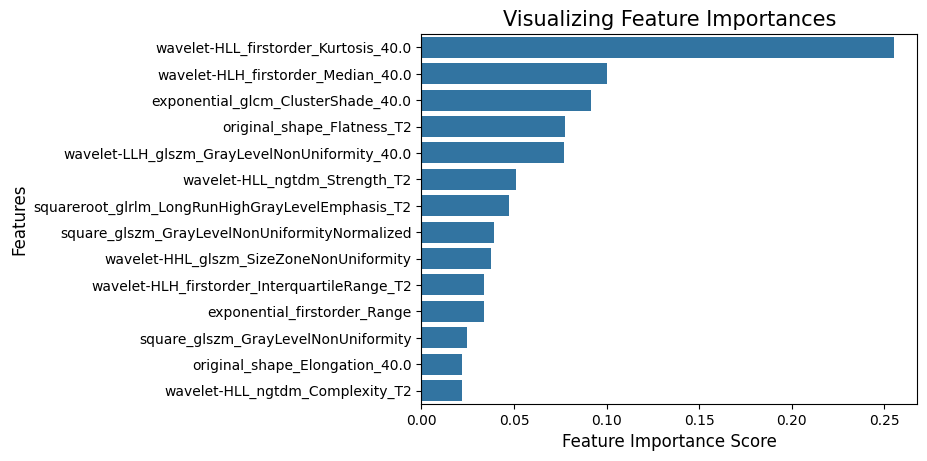

In [22]:
feature_imp_shape = pd.Series(grid_search_randomforest_all_shape.feature_importances_, index=X_train_all.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_shape[:14], y=feature_imp_shape[:14].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

Text(0.5, 1.0, 'Visualizing Feature Importances')

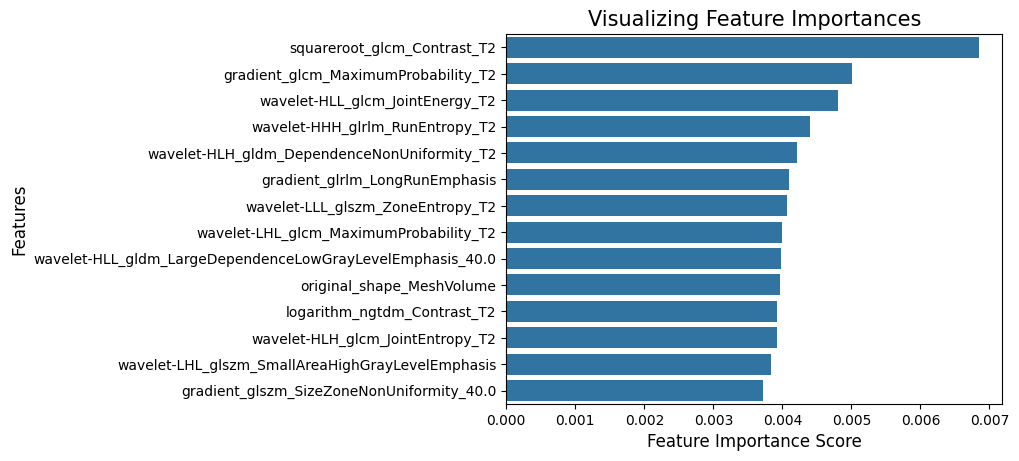

In [23]:
feature_imp_margins = pd.Series(grid_search_randomforest_all_margins.feature_importances_, index=X_train_all.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_margins[:14], y=feature_imp_margins[:14].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [24]:
val_rf_shape = feature_imp_shape.sort_values(ascending=False)
val_rf_margins = feature_imp_margins.sort_values(ascending=False)

best_params_rf_restricted_nb_of_features_shape, grid_search_rf_restricted_nb_of_features_shape = grid_search_rf(X_train_all[val_rf_shape.keys()[:5]], shape_target_train.values.ravel(), skf)
best_params_rf_restricted_nb_of_features_margins, grid_search_rf_restricted_nb_of_features_margins = grid_search_rf(X_train_all[val_rf_margins.keys()[:5]], margins_target_train.values.ravel(), skf, unbalance=False)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


In [25]:
def retrain_cv_for_roc_curve_display(model, X, y, kfolds):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(kfolds.split(X, y)):
        print(np.array(y)[train].shape)
        model.fit(np.array(X)[train], np.array(y)[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            np.array(X)[test],
            np.array(y)[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

In [26]:
grid_search_rf_restricted_nb_of_features_margins.best_estimator_

RandomForestClassifier(max_depth=4, max_features=None, n_estimators=50,
                       random_state=123)

In [27]:
grid_search_rf_restricted_nb_of_features_shape.best_estimator_

RandomForestClassifier(max_depth=4, max_features=None, n_estimators=150,
                       random_state=123)

(108, 1)
(109, 1)
(109, 1)
(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


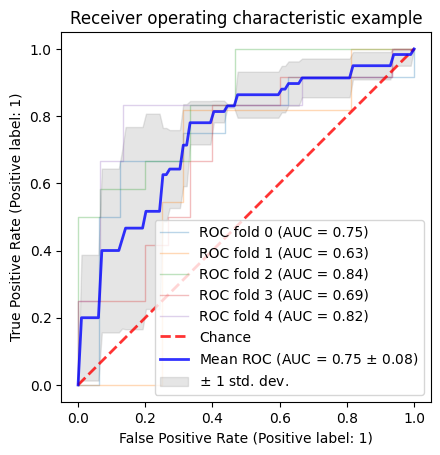

In [28]:
retrain_cv_for_roc_curve_display(grid_search_rf_restricted_nb_of_features_margins.best_estimator_, X_train_all[val_rf_margins.keys()[:5]], margins_target_train.values, skf)

(108, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(109, 1)


/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


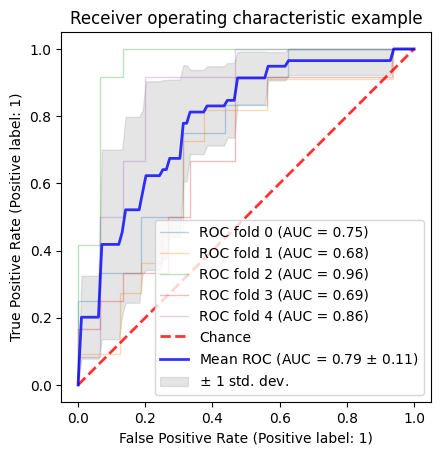

In [29]:
retrain_cv_for_roc_curve_display(grid_search_randomforest_MJ_margins, X_train_margins_MJ, margins_target_train.values, skf)

In [30]:
comp_results = [compile_results(x, (X_train_shape_MJ if x==grid_search_randomforest_MJ_shape else X_train_all[val_rf_shape.keys()[:5]]), shape_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_shape, grid_search_rf_restricted_nb_of_features_shape.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Random Forest published', 'Random Forest 5 features'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [31]:
results

,Random Forest published,Random Forest 5 features
roc_auc,"(0.66, 0.11)","(0.81, 0.1)"
balanced_accuracy,"(0.68, 0.11)","(0.63, 0.07)"
precision,"(0.44, 0.11)","(0.65, 0.3)"
recall,"(0.59, 0.21)","(0.38, 0.15)"
f1,"(0.49, 0.14)","(0.41, 0.12)"
specificity,"(0.77, 0.06)","(0.88, 0.11)"
sensitivity,"(0.59, 0.21)","(0.38, 0.15)"
youden_index,"(0.36, 0.22)","(0.25, 0.14)"


In [32]:
comp_results = [compile_results(x, (X_train_margins_MJ if x==grid_search_randomforest_MJ_margins else X_train_all[val_rf_margins.keys()[:5]]), margins_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_margins, grid_search_rf_restricted_nb_of_features_margins.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Random Forest published', 'Random Forest 5 features'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [33]:
results

,Random Forest published,Random Forest 5 features
roc_auc,"(0.79, 0.11)","(0.75, 0.08)"
balanced_accuracy,"(0.77, 0.1)","(0.73, 0.04)"
precision,"(0.68, 0.12)","(0.7, 0.08)"
recall,"(0.88, 0.11)","(0.73, 0.08)"
f1,"(0.76, 0.11)","(0.71, 0.03)"
specificity,"(0.66, 0.16)","(0.74, 0.11)"
sensitivity,"(0.88, 0.11)","(0.73, 0.08)"
youden_index,"(0.55, 0.21)","(0.47, 0.08)"


In [34]:
def compute_pred(model, X_test):
    return model.predict(X_test)

RandomForestClassifier(max_depth=4, max_features=None, n_estimators=50,
                       random_state=123)
sensitivity: 0.7894736842105263
specificity: 0.4838709677419355
youden_index: 0.2733446519524618
balanced_accuracy: 0.6366723259762309
roc_auc: 0.6366723259762309
precision: 0.4838709677419355
recall: 0.7894736842105263
              precision    recall  f1-score   support

           0       0.79      0.48      0.60        31
           1       0.48      0.79      0.60        19

    accuracy                           0.60        50
   macro avg       0.64      0.64      0.60        50
weighted avg       0.67      0.60      0.60        50



/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/psteinmetz/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWar

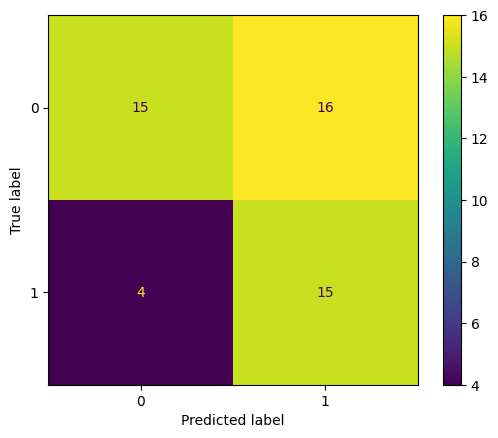

In [35]:
for model in [grid_search_rf_restricted_nb_of_features_margins.best_estimator_, grid_search_randomforest_MJ_margins]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }

    if model == grid_search_rf_restricted_nb_of_features_margins.best_estimator_:
        y_pred = compute_pred(model, data_eval[val_rf_margins.keys()[:5]])
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)+ scoring['sensitivity'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, data_eval[val_rf_margins.keys()[:5]], margins_target_eval)))

        print(classification_report(margins_target_eval.values.ravel(), y_pred))
        cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
        disp.plot()
    

RandomForestClassifier(max_depth=4, max_features=None, n_estimators=150,
                       random_state=123)
sensitivity: 0.15384615384615385
specificity: 0.8378378378378378
youden_index: -0.008316008316008316
balanced_accuracy: 0.49584199584199584
roc_auc: 0.4958419958419958
precision: 0.25
recall: 0.15384615384615385
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        37
           1       0.25      0.15      0.19        13

    accuracy                           0.66        50
   macro avg       0.49      0.50      0.49        50
weighted avg       0.61      0.66      0.63        50



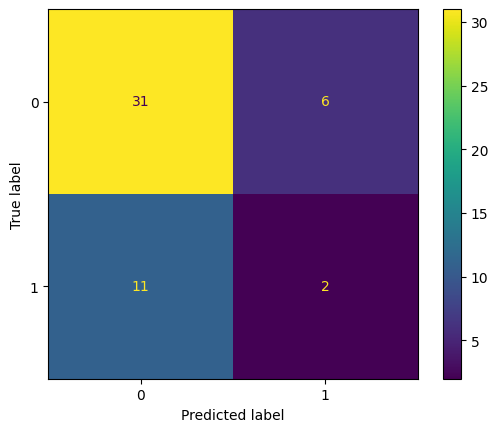

In [36]:
for model in [grid_search_rf_restricted_nb_of_features_shape.best_estimator_, grid_search_randomforest_MJ_shape]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }

    if model == grid_search_rf_restricted_nb_of_features_shape.best_estimator_:
        y_pred = compute_pred(model, data_eval[val_rf_shape.keys()[:5]])
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)+ scoring['sensitivity'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, data_eval[val_rf_shape.keys()[:5]], shape_target_eval)))

        print(classification_report(shape_target_eval.values.ravel(), y_pred))
        cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
        disp.plot()
    


In [ ]:
corr_shape = abs(X_train_all.corr()[val_rf_shape.keys()[:5]])
corr_margins = abs(X_train_all.corr()[val_rf_margins.keys()[:5]])

In [ ]:
list_shape = [pd.Series(corr_shape.iloc[:, x][(corr_shape.iloc[:, x]>0.8) & (corr_shape.iloc[:, x]<1)]) for x in range(5)] 
list_margins = [pd.Series(corr_margins.iloc[:, x][(corr_margins.iloc[:, x]>0.8) & (corr_margins.iloc[:, x]<1)]) for x in range(5)] 

In [ ]:
list_margins[3].sort_values(ascending=False)

In [ ]:
list_shape[0].sort_values(ascending=False)

In [ ]:
corr_shape[corr_shape.iloc[:, 1]>0.8]

In [ ]:
corr_shape[corr_shape.iloc[:, 2]>0.8]

In [ ]:
X_train_all[val_rf_shape.keys()[:5]].corrwith(X_train_all.drop(val_rf_shape.keys()[:5], axis=1))

In [ ]:
[val_rf_margins.keys()[:5]]

In [ ]:
comp_results = [compile_results(x, (X_train_margins_MJ if x==grid_search_randomforest_MJ_margins.best_estimator_ else X_train_all[val_rf_margins.keys()[:5]]), margins_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_margins.best_estimator_, grid_search_rf_restricted_nb_of_features_margins.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Random Forest MJ', 'Random Forest all'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [ ]:
results

In [ ]:
comp_results = [compile_results(x, (X_train_shape_MJ if x==grid_search_randomforest_MJ_shape.best_estimator_ else X_train_all[val_rf_shape.keys()[:5]]), shape_target_train.values.ravel(), skf, True) for x in [grid_search_randomforest_MJ_shape.best_estimator_, grid_search_rf_restricted_nb_of_features_shape.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Random Forest MJ', 'Random Forest all'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [ ]:
results